In [1]:
import sys
sys.setrecursionlimit(10000)

import random
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pylab as plt
plt.style.use("ggplot") 

from scipy import linalg
from gensim.models import word2vec
from sklearn.model_selection import RepeatedKFold
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix, plot_confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score, roc_auc_score
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import hamming_loss

import data_helpers
from data_helpers import *
import imp
imp.reload(data_helpers)


<module 'data_helpers' from '/Users/kyrylo/Projects/personal/thesis/data_helpers.py'>

In [2]:
df_se_skills = pd.read_csv(PREPROCESSED_SE_SKILLS_PATH)
df_se_subtracks = pd.read_csv(PREPROCESSED_SE_TRACKS_PATH)

se_skill_names = list(df_se_skills[SKILL_TAG_LABEL])
skill_names = list_mask(df_se_subtracks.columns.to_list(), se_skill_names)
print('Total skills count:', len(skill_names))

track_names = list_mask(skill_names, list(df_se_skills[df_se_skills[IS_TRACK_NAME_LABEL] == True][SKILL_TAG_LABEL]))
skill_names = list_filter(skill_names, track_names)
country_columns = ['COUNTRY_DE','COUNTRY_EE','COUNTRY_FI','COUNTRY_LT','COUNTRY_LV','COUNTRY_PK']
be_skill_names = df_se_skills[SKILL_TAG_LABEL][df_se_skills[IS_BE_LABEL] == True].to_list()
fe_skill_names = df_se_skills[SKILL_TAG_LABEL][df_se_skills[IS_FE_LABEL] == True].to_list()

for skill in skill_names:
    df_se_subtracks[skill] = np.where(df_se_subtracks[skill] > 0, 1 , 0)

df_se_subtracks

Total skills count: 133


ID  TYPE  SENIORITY  \
0      e66911f13061f2226be06c25     0   1.000000   
1      276911f13061f2226be06c25     0   1.000000   
2      e76911f13061f2226be06c25     0   1.000000   
3      f8343b8716ee6a873cfa2dc5     0   1.000000   
4      296911f13061f2226be06c25     0   0.333333   
...                         ...   ...        ...   
40842  6f28bd2100c4c70e6f99cf15     1   1.000000   
40843  de11cc210041983e4a997f35     1   1.000000   
40844  4ee295210002395f262f3ff5     1   1.000000   
40845  dc00042100a3628f746d5f65     1   1.000000   
40846  b512af3031025ea097ad4086     1   0.666667   

                                                   TITLE  COUNTRY_DE  \
0                                              Developer           0   
1                                   Full Stack Developer           0   
2                                Developer, Scrum Master           0   
3                                              Developer           1   
4                                       Junior developer           0   
...                                                  ...         ...   
40842  Senior/Lead SW developer (Backend/Full Stack/AWS)           0   
40843  Experienced Software Developer (Backend/Fronte...           0   
40844                               Senior PHP developer           0   
40845                    Fullstack developer (part-time)           0   
40846        QA Test Automation / JAVA Software Engineer           0   

       COUNTRY_EE  COUNTRY_FI  COUNTRY_LT  COUNTRY_LV  COUNTRY_PK  ...  \
0               1           0           0           0           0  ...   
1               1           0           0           0           0  ...   
2               1           0           0           0           0  ...   
3               0           0           0           0           0  ...   
4               1           0           0           0           0  ...   
...           ...         ...         ...         ...         ...  ...   
40842           0           1           0           0           0  ...   
40843           0           1           0           0           0  ...   
40844           1           0           0           0           0  ...   
40845           1           0           0           0           0  ...   
40846           1           0           0           0           0  ...   

       software_engineering_tool__unity  \
0                                     0   
1                                     0   
2                                     0   
3                                     0   
4                                     0   
...                                 ...   
40842                                 0   
40843                                 0   
40844                                 0   
40845                                 0   
40846                                 0   

       software_engineering_tool__unreal_engine  \
0                                             0   
1                                             0   
2                                             0   
3                                             0   
4                                             0   
...                                         ...   
40842                                         0   
40843                                         0   
40844                                         0   
40845                                         0   
40846                                         0   

       software_engineering_tool__vaadin  software_engineering_tool__vagrant  \
0                                      0                                   0   
1                                      0                                   0   
2                                      0                                   0   
3                                      0                                   0   
4                                      0                                   0   
...                                  ...

# Drop profiles with low # of skills

In [3]:
print('Dropped', df_se_subtracks.loc[df_se_subtracks[skill_names].sum(axis=1) <= 2].shape[0])

df_se_subtracks = df_se_subtracks.loc[df_se_subtracks[skill_names].sum(axis=1) > 2]
df_se_subtracks

Dropped 2737


ID  TYPE  SENIORITY  \
0      e66911f13061f2226be06c25     0   1.000000   
1      276911f13061f2226be06c25     0   1.000000   
2      e76911f13061f2226be06c25     0   1.000000   
3      f8343b8716ee6a873cfa2dc5     0   1.000000   
4      296911f13061f2226be06c25     0   0.333333   
...                         ...   ...        ...   
40842  6f28bd2100c4c70e6f99cf15     1   1.000000   
40843  de11cc210041983e4a997f35     1   1.000000   
40844  4ee295210002395f262f3ff5     1   1.000000   
40845  dc00042100a3628f746d5f65     1   1.000000   
40846  b512af3031025ea097ad4086     1   0.666667   

                                                   TITLE  COUNTRY_DE  \
0                                              Developer           0   
1                                   Full Stack Developer           0   
2                                Developer, Scrum Master           0   
3                                              Developer           1   
4                                       Junior developer           0   
...                                                  ...         ...   
40842  Senior/Lead SW developer (Backend/Full Stack/AWS)           0   
40843  Experienced Software Developer (Backend/Fronte...           0   
40844                               Senior PHP developer           0   
40845                    Fullstack developer (part-time)           0   
40846        QA Test Automation / JAVA Software Engineer           0   

       COUNTRY_EE  COUNTRY_FI  COUNTRY_LT  COUNTRY_LV  COUNTRY_PK  ...  \
0               1           0           0           0           0  ...   
1               1           0           0           0           0  ...   
2               1           0           0           0           0  ...   
3               0           0           0           0           0  ...   
4               1           0           0           0           0  ...   
...           ...         ...         ...         ...         ...  ...   
40842           0           1           0           0           0  ...   
40843           0           1           0           0           0  ...   
40844           1           0           0           0           0  ...   
40845           1           0           0           0           0  ...   
40846           1           0           0           0           0  ...   

       software_engineering_tool__unity  \
0                                     0   
1                                     0   
2                                     0   
3                                     0   
4                                     0   
...                                 ...   
40842                                 0   
40843                                 0   
40844                                 0   
40845                                 0   
40846                                 0   

       software_engineering_tool__unreal_engine  \
0                                             0   
1                                             0   
2                                             0   
3                                             0   
4                                             0   
...                                         ...   
40842                                         0   
40843                                         0   
40844                                         0   
40845                                         0   
40846                                         0   

       software_engineering_tool__vaadin  software_engineering_tool__vagrant  \
0                                      0                                   0   
1                                      0                                   0   
2                                      0                                   0   
3                                      0                                   0   
4                                      0                                   0   
...                                  ...

# Drop minor classes

In [4]:
minor_cluster_names = df_se_subtracks[CLUSTER_LABEL].value_counts().to_frame().query('CLUSTER  < 10').index
rows_from_minro_clasters = df_se_subtracks[CLUSTER_LABEL].isin(minor_cluster_names).to_frame().query('CLUSTER  == True').index

print('Dropped rows:', rows_from_minro_clasters.shape)

df_se_subtracks.drop(rows_from_minro_clasters, inplace=True)
df_se_subtracks.reset_index(drop=True, inplace=True)

df_se_subtracks

Dropped rows: (12834,)


/usr/local/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ID  TYPE  SENIORITY  \
0      e66911f13061f2226be06c25     0   1.000000   
1      276911f13061f2226be06c25     0   1.000000   
2      e76911f13061f2226be06c25     0   1.000000   
3      f8343b8716ee6a873cfa2dc5     0   1.000000   
4      39108e16d196f7de86bb7c05     0   1.000000   
...                         ...   ...        ...   
25271  dd41b1210012296e07987fc5     1   1.000000   
25272  6f28bd2100c4c70e6f99cf15     1   1.000000   
25273  de11cc210041983e4a997f35     1   1.000000   
25274  dc00042100a3628f746d5f65     1   1.000000   
25275  b512af3031025ea097ad4086     1   0.666667   

                                                   TITLE  COUNTRY_DE  \
0                                              Developer           0   
1                                   Full Stack Developer           0   
2                                Developer, Scrum Master           0   
3                                              Developer           1   
4                                   Senior iOS Developer           0   
...                                                  ...         ...   
25271                    Senior/Lead Mobile SW developer           0   
25272  Senior/Lead SW developer (Backend/Full Stack/AWS)           0   
25273  Experienced Software Developer (Backend/Fronte...           0   
25274                    Fullstack developer (part-time)           0   
25275        QA Test Automation / JAVA Software Engineer           0   

       COUNTRY_EE  COUNTRY_FI  COUNTRY_LT  COUNTRY_LV  COUNTRY_PK  ...  \
0               1           0           0           0           0  ...   
1               1           0           0           0           0  ...   
2               1           0           0           0           0  ...   
3               0           0           0           0           0  ...   
4               1           0           0           0           0  ...   
...           ...         ...         ...         ...         ...  ...   
25271           0           1           0           0           0  ...   
25272           0           1           0           0           0  ...   
25273           0           1           0           0           0  ...   
25274           1           0           0           0           0  ...   
25275           1           0           0           0           0  ...   

       software_engineering_tool__unity  \
0                                     0   
1                                     0   
2                                     0   
3                                     0   
4                                     1   
...                                 ...   
25271                                 0   
25272                                 0   
25273                                 0   
25274                                 0   
25275                                 0   

       software_engineering_tool__unreal_engine  \
0                                             0   
1                                             0   
2                                             0   
3                                             0   
4                                             0   
...                                         ...   
25271                                         0   
25272                                         0   
25273                                         0   
25274                                         0   
25275                                         0   

       software_engineering_tool__vaadin  software_engineering_tool__vagrant  \
0                                      0                                   0   
1                                      0                                   0   
2                                      0                                   0   
3                                      0                                   0   
4                                      0                                   0   
...                                  ...

## Test / Train splitting 

In [5]:
X_columns = [*skill_names, *track_names]

X_train, X_val = train_test_split(df_se_subtracks[X_columns], test_size=0.3, random_state=0, stratify=df_se_subtracks['CLUSTER'])

features_set = list(df_se_subtracks[skill_names].sum().sort_values(ascending=False).nlargest(30).index)

print(X_train.shape, X_val.shape)

(17693, 133) (7583, 133)


In [6]:
_X_val = pd.DataFrame(columns=X_train.columns)
_y_val = np.array([])

for skill in features_set:
    X_val_for_skill = X_val.loc[X_val[skill]>0].copy()
    X_val_for_skill[skill] = 0
    _X_val = _X_val.append(X_val_for_skill)
    
    y_val_for_skill = np.repeat(skill, X_val_for_skill.shape[0])
    _y_val = np.append(_y_val, y_val_for_skill)
    

_X_val.reset_index(drop=True, inplace=True)
X_val = _X_val.copy()
y_val = _y_val.copy()

    
print('Train:', X_train.shape, 'Val:', X_val.shape, y_val.shape)

Train: (17693, 133) Val: (42332, 133) (42332,)


In [7]:
X_train = pd.Series(get_words_from_wordcounts(X_train[[*track_names,*skill_names]]))
X_val = pd.Series(get_words_from_wordcounts(X_val[[*track_names,*skill_names]]))

In [8]:
def mmr_score(expected, predicted_list, n):
    target_list = predicted_list[:n]
    
    if expected in target_list:
        return 1 / (target_list.index(expected) + 1)
    
    if (len(target_list) < n):
        print('Not enough samples')
        
    return 0

In [12]:
RECOMMENDATIONS_COUNT = 30
PARAM_SORTED_VOCAB = 1 # 1
PARAM_RESTRICT_VOCAB = 50 # 18, 17-20 ? or 40
PARAM_ITER = 20 # 20 ?
PARAM_WORKERS = 10 # 10
PARAM_ALPHA = 0.035 # 0.035 ?
PARAM_WINDOW = 10 # 10
PARAM_SIZE = 6 # 6

mmr_scores_10 = []
mmr_scores_5 = []
mmr_scores_3 = []


model = word2vec.Word2Vec(X_train,
                             size=PARAM_SIZE, 
                             window=PARAM_WINDOW,
                             min_count=0,
                             seed=0,
                             workers=PARAM_WORKERS,
                             sorted_vocab=PARAM_SORTED_VOCAB,
                             iter=PARAM_ITER,
                             alpha = PARAM_ALPHA,
#                            min_alpha=0.0005,
                             sg=1)

y_pred = []

for ix in range(len(X_val)):
    profile = X_val[ix]
    profile_predictions = model.wv.most_similar(
                             positive=profile, 
                             topn=RECOMMENDATIONS_COUNT, 
                             restrict_vocab=PARAM_RESTRICT_VOCAB)
    predictions = list_mask([skill[0] for skill in profile_predictions], features_set)
    result = predictions[0]
    
    mmr_scores_10.append(mmr_score(y_val[ix], predictions, 10))
    mmr_scores_5.append(mmr_score(y_val[ix], predictions, 5))
    mmr_scores_3.append(mmr_score(y_val[ix], predictions, 3))
    

    y_pred.append(result)
    

    sys.stdout.write("\r Profile " + str(ix + 1) + '/' + str(X_val.shape[0]))
    sys.stdout.flush() 


 Profile 42332/42332

acc 0.2703864688651611
recall 0.2703864688651611
precesion 0.42489251314131227
f1 0.28345329931625035
MRR_10 0.43626574665268797
MRR_5 0.41156926202400074
MRR_3 0.37769299820466784


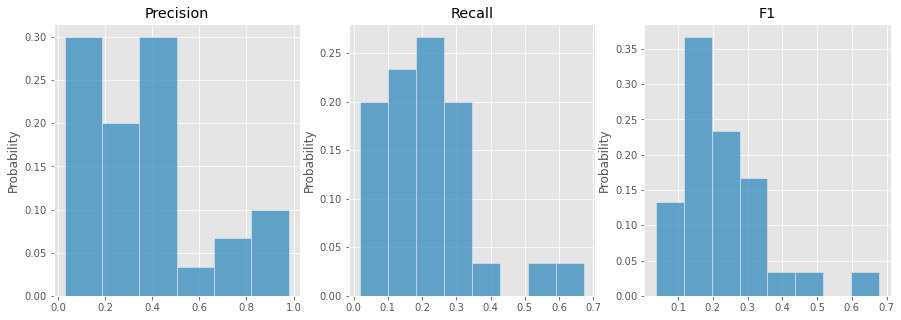

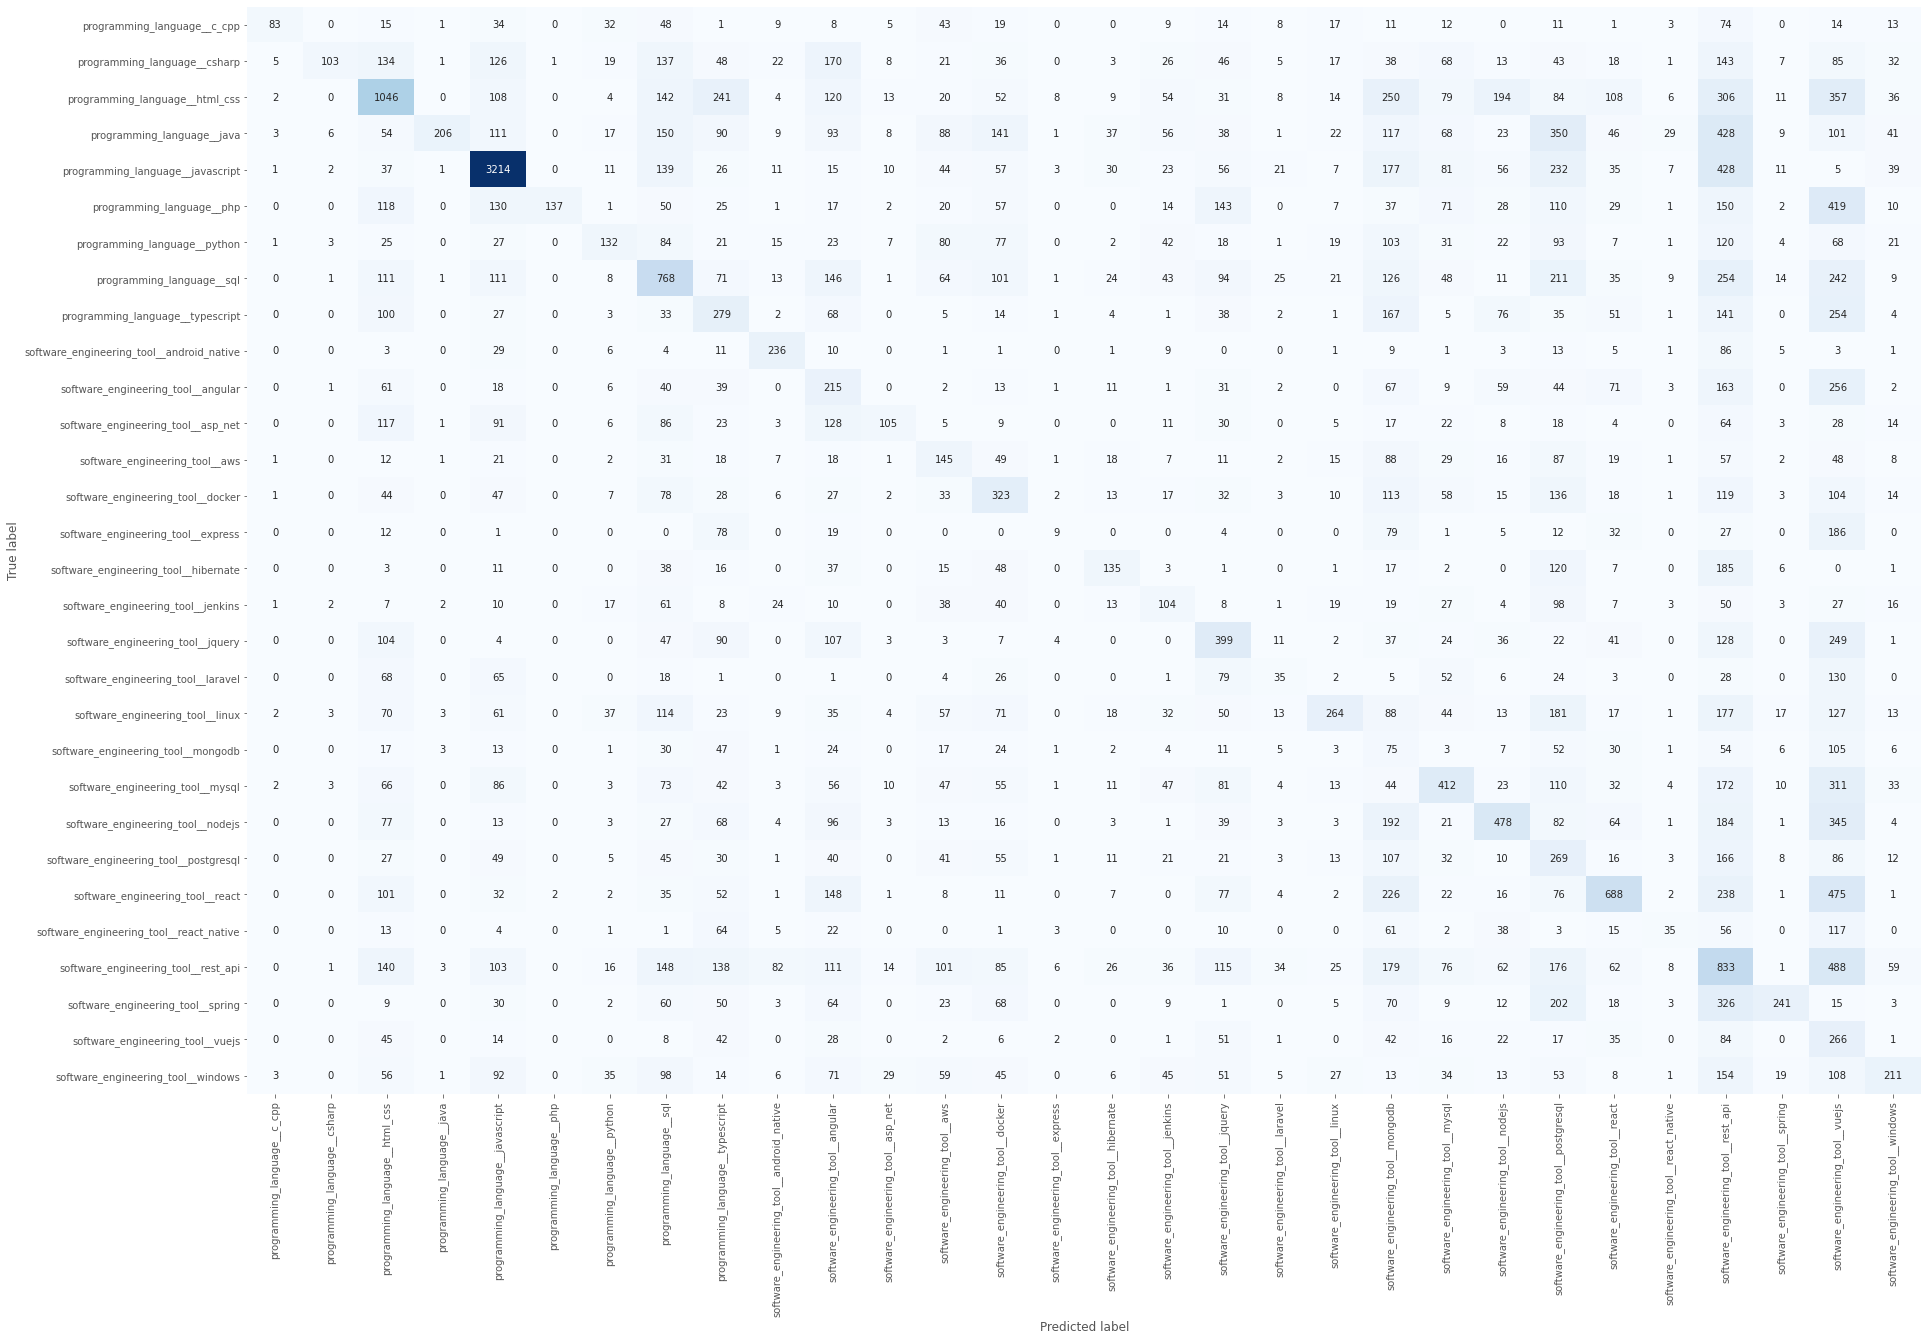

In [13]:
def display_scores(actual, pred):
    print('acc', accuracy_score(actual, pred))
    print('recall', recall_score(actual, pred, average = "weighted"))
    print('precesion', precision_score(actual, pred, average = "weighted"))
    print('f1', f1_score(actual, pred, average = "weighted"))
    print('MRR_10', np.mean(mmr_scores_10))
    print('MRR_5', np.mean(mmr_scores_5))
    print('MRR_3', np.mean(mmr_scores_3))
    
    fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(15,5))
    sns.histplot(precision_score(actual, pred, average = None), stat='probability', ax=ax1).set(title='Precision')
    sns.histplot(recall_score(actual, pred, average = None), stat='probability', ax=ax2).set(title='Recall')
    sns.histplot(f1_score(actual, pred, average = None), stat='probability', ax=ax3).set(title='F1')
    plt.show()

display_scores(_y_val, y_pred)

make_confusion_matrix(confusion_matrix(_y_val, y_pred, labels=np.unique(y_pred)), figsize=(30,20), 
                      count=True,
                      percent=False,
                      sum_stats=False,
                      categories=np.unique(y_pred), cbar=False)

# acc 0.2678824529906454
# recall 0.2678824529906454
# precesion 0.4241900633648709
# f1 0.27970528738004935

## Validation

In [11]:
RECOMMENDATIONS_COUNT = 1
PARAM_SORTED_VOCAB = 1 # 1
PARAM_RESTRICT_VOCAB = 40 # 18, 17-20 ? or 40
PARAM_ITER = 20 # 20 ?
PARAM_WORKERS = 1 # 1
PARAM_ALPHA = 0.035 # 0.035 ?
PARAM_WINDOW = 4 # 4 ?
PARAM_SIZE = 6 # 6
    

param_values = [30,40,50]
model_acc = []

for param_value in param_values:
    def predict(model, X):
        predicted_skills_probs = model.wv.most_similar(
                             positive=profile_without_expected_skills, 
                             topn=RECOMMENDATIONS_COUNT, 
                             restrict_vocab=param_value)
        return [result[0] for result in predicted_skills_probs]
    
    def get_model(X_train):
        return word2vec.Word2Vec(X_train,
                             size=PARAM_SIZE, 
                             window=PARAM_WINDOW,
                             min_count=0,
                             seed=0,
                             workers=PARAM_WORKERS,
                             sorted_vocab=PARAM_SORTED_VOCAB,
                             iter=PARAM_ITER,
                             alpha = PARAM_ALPHA,
#                            min_alpha=0.0005,
                             sg=0)

    for train_index, val_index in RepeatedKFold(n_splits=5, n_repeats=1, random_state=111).split(features_set):
        X_train = profiles_skill_names[train_index]
        X_val = profiles_skill_names[val_index]
        fold_acc = []

        model = get_model(X_train) 

        for profile_skills in X_val:
            profile_skills = list_mask(profile_skills, list(model.wv.vocab))

            for expected_skill in profile_skills:
                expected_skills = [expected_skill]
                profile_without_expected_skills = list_filter(profile_skills, expected_skills)

                predicted_skills = predict(model, profile_without_expected_skills)

                fold_acc.append(evaluate_by_restored_count(expected_skills, predicted_skills))
        
        print('Fold acc: ', np.mean(fold_acc)) 
    
    model_acc.append(np.mean(fold_acc))    
    

fig, ax = plt.subplots(1)
ax.plot(param_values, model_acc, 'o-')
ax.set_ylabel('Accuracy')
plt.show()

NameError: name 'profiles_skill_names' is not defined

In [ ]:
model = word2vec.Word2Vec(profiles_skill_names,
                             size=PARAM_SIZE, 
                             window=PARAM_WINDOW,
                             min_count=0,
                             seed=0,
                             workers=PARAM_WORKERS,
                             sorted_vocab=PARAM_SORTED_VOCAB,
                             iter=PARAM_ITER,
                             alpha = PARAM_ALPHA,
#                            min_alpha=0.0005,
                             sg=1)

In [ ]:
profiles_skill_names[2543]

In [ ]:
positive = ['programming_language__java',
       'software_engineering_tool__linux',
       'software_engineering_tool__windows',
       'software_engineering__backend_development',
       'software_engineering__full_stack_development']
negative = []


list_mask([skill[0] for skill in model.wv.most_similar(positive=positive,negative=negative, topn=40, restrict_vocab=200)], features_set)